**Import Modules**

In [ ]:
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
from matplotlib import rcParams
rcParams["figure.dpi"] = 150

**Read File**

In [ ]:
with open("mpd.slice.0-999.json", "r") as file:
  data = json.load(file)

**Song & Graph Class**

In [ ]:
class Song:

    def __init__(self, title, artist, title_id=0, artist_id=0, index=-1):

        # Attributes
        self.title = title
        self.artist = artist
        self.title_id = title_id
        self.artist_id = artist_id
        self.index = index
        return

    # Getters
    def set_title(self, title):
        self.title = title
        return
    def set_artist(self, artist):
        self.title = artist
        return
    def set_title_id(self, title_id):
        self.title = title_id
        return
    def set_artist_id(self, artist_id):
        self.artist_id = artist_id
        return
    def set_index(self, index):
        self.index = index
        return

    # Setters
    def get_title(self): return self.title
    def get_artist(self): return self.artist_id
    def get_title_id(self): return self.title_id
    def get_artist_id(self): return self.artist_id
    def get_index(self): return self.index

class Graph:
    def __init__(self, n=0, nodes=[], adj=np.zeros((0,0), int)):
        # Attribute
        self.n = n
        self.nodes = list(nodes)
        self.adj = adj

        return

    def set_n(self, n):
        difference = self.n - n
        self.n = n
        for i in range(difference):
            self.cost += [[]]
        return

    def set_node(self, node):
        self.nodes.append(node)
        self.adj = np.pad(self.adj, pad_width=((0, 1), (0, 1)), mode='constant', constant_values=0)
        return

    def add_cost(self, i, j, cost=1):
        self.adj[i][j] = self.get_cost(i, j) + cost
        self.adj[j][i] = self.get_cost(j, i) + cost
        return

    def get_n(self): return self.n
    def get_node(self, n): return self.nodes[n]
    def get_cost(self, i, j): return self.adj[i][j]
    def get_nodes(self):
        output = []
        for node in self.nodes:
            output += [node.get_title()]
        return output

    def get_adj(self): return self.adj

    def comp_pop(self):
        output = []
        for i in range(self.adj.shape[0]):
          output += [(i, self.adj[i].sum())]
        return

    def set_diag_zero(self):
        np.fill_diagonal(self.adj, 0)
        return

**Read Graph Class, Optimal Search, Markov Chain Recommendation**

In [ ]:
def setup_graph(input):
    output = Graph() # initialize a graph object
    position = 0 # record the position of each node on the nodes list of the graph
    indices = {} # map the title of each song to its index on the nodes list
    counter = 1
    song_set = set()

    for playlist in tqdm(input["playlists"][:100], desc="Processing Playlist"): # iterate through the playlist
        prev = [] # record the songs that is in a particular playlist

        counter += 1

        for song in playlist["tracks"]: # iterate through the songs in playlist
            if song["album_name"] not in song_set: # add the song to the graph if it is not added
                output.set_node(Song(song["album_name"], song["artist_name"]))
                indices[song["album_name"]] = [position, song["artist_name"]]
                prev += [song["album_name"]]
                position += 1
            else:
                prev += [song["album_name"]] # if song already in graph then just add to the previous in the playlist
                song_set.add(song["album_name"])

        # change the cost of the nodes that occured in the same playlist by 1
        for i in range(len(prev)):
            for j in range(i+1, len(prev)):
                output.add_cost(indices[prev[i]][0], indices[prev[j]][0])

    output.set_diag_zero()

    return output, indices

def optimal_search(playlist, song_graph, song_indices):

      # numpy array of all song
      all_song = np.array(song_graph.get_adj(), dtype = int)
      # vectors of the song from input playlist
      n_song = np.zeros(song_graph.get_adj().shape[0], dtype=int)

      # Store the song vectors into an array of their own
      # Set the row vector of the song on the playlist in the original matrix to 0
      for index in playlist:
        if np.all(n_song == np.zeros(all_song.shape[0], dtype=int)):
          n_song = np.array(all_song[song_indices[index][0]])
          all_song[song_indices[index][0]] = np.zeros(all_song.shape[0], dtype=int)
        else:
          n_song = np.vstack([n_song, np.array(all_song[song_indices[index][0]])])
          all_song[song_indices[index][0]] = np.zeros(all_song.shape[0], dtype=int)

      projection = np.dot(n_song, all_song.T)
      projection = projection.T

      # Vector That Represent the similiarity between each song
      # given by the sum of the projection onto basis of the playlist subspace
      sim_vector = projection.sum(axis=1)
      index = np.arange(0, 6100)
      sim_vector = np.vstack([sim_vector, index]).T

      # Sort the similiarity vector to find the index with greatest projection
      sorted_indices = np.argsort(sim_vector[:, 0])
      sorted_sim = sim_vector[sorted_indices]
      sorted_sim = sorted_sim[::-1]

      return sorted_sim

def recommendation(playlist, all_song_graph,  all_song_info, num_rec, display_result):

  # Given a playlist find the songs that may be interest to the user,
  # record its indices as a list
  ranked_songs = optimal_search(playlist, all_song_graph, all_song_info)
  ranked_songs_indices = ranked_songs[:num_rec, 1].tolist()

  # Given the indices of interest, construct a brand new adjacency matrix
  # with only the song of interest
  selected_song_array = []
  full_song_matrix = all_song_graph.get_adj();

  for i in ranked_songs_indices:
    row = []
    for j in ranked_songs_indices:
      if i == j:
        row.append(0)
      else:
        row.append(full_song_matrix[i, j])
    selected_song_array.append(list(row))

  ranked_song_matrix = np.array(selected_song_array, dtype=float)

  # Modify the column of the adjacency matrix such that it is column stochastic
  # this allows us to applied the markov chain of the page rank algorithm
  # since stochastic matrices will converege as times goes to infinity
  for j in range(ranked_song_matrix.shape[1]):
    ranked_song_matrix[:, j] = ranked_song_matrix[:, j] / ranked_song_matrix[:, j].sum()

  # Compute the eigenvector which represent the probability of adding a song as
  # we move the markov chain forward in time
  # Sort the probability given by the eigenvector and find its corresponding song indices
  eigenvector, eigenvalue = shift_invert_pi(18, 0.99, ranked_song_matrix, False)
  eigenvector = np.vstack([eigenvector, ranked_songs[:eigenvector.shape[0], 1]]).T

  sorted_recommendation_indices = np.argsort(eigenvector[:, 0])
  sorted_recommendation = eigenvector[sorted_recommendation_indices]
  sorted_recommendation = np.array(sorted_recommendation[::-1][:,1], dtype=int)

  if display_result:
    print("Given the following playlist:")
    for i in range(len(playlist)):
      print("\t", str(i+1)+".", playlist[i], "by",  all_song_info[playlist[i]][1])
    print()
    print("We Recommend the following song ranking from most compatible to moderately compatible:")
    for i in range(len(sorted_recommendation)):
      index = sorted_recommendation[i]
      title = all_song_graph.get_nodes()[index]
      artist = all_song_info[title][1]
      print("\t", str(i+1)+".", title, "by", artist)

  return


**Numerical Approximation of Eigenvectors: Power Iteration & Shift Invert Power Iteration**

[0.72101209 0.24034439 0.54075241 0.36050376] 0.999999659207838


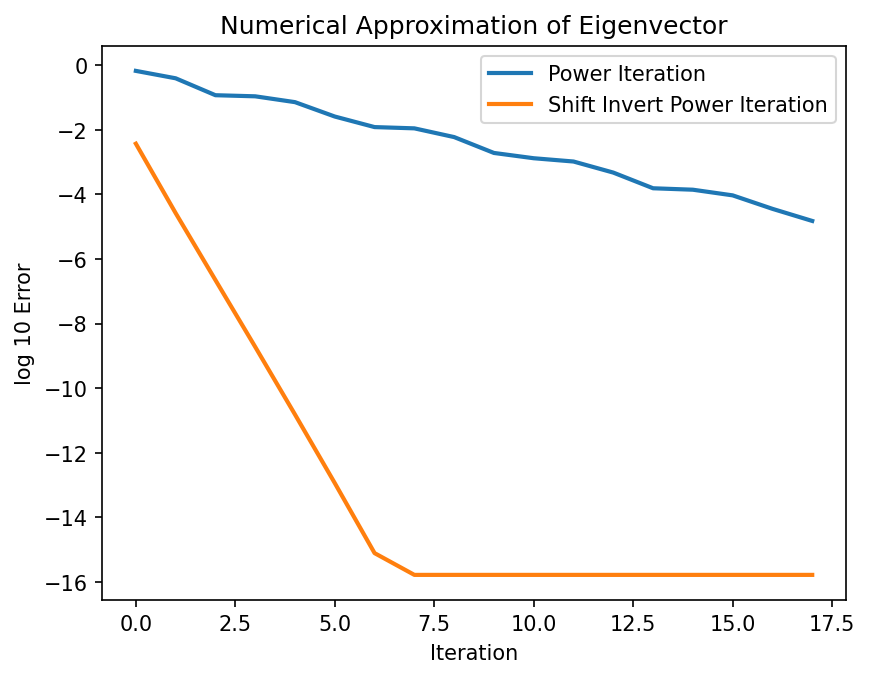

[0.72101012 0.24033671 0.54075759 0.36050506] 1.0000000000000002


In [ ]:
def power_iteration(k, input):
  x = np.random.random(input.shape[0])
  x = x / np.linalg.norm(x)
  y = 0
  eigenval = 0
  error = []

  for i in range(k):
    y = np.dot(A, x)
    x = y / np.linalg.norm(y)
    eigenval = np.dot(x.T, np.dot(A, x))
    error.append(np.linalg.norm(np.dot(A, x)-x))

  error = np.array(error)
  plt.plot(range(k), np.log10(error), label="Power Iteration", linewidth=2)
  plt.ylabel("log 10 Error")
  plt.xlabel("Iteration")

  return x, eigenval

def shift_invert_pi(k, sigma, input, show_convergence=True):
  x = np.random.random(input.shape[0])
  x = x / np.linalg.norm(x)
  y = 0
  sigma = sigma
  eigenval = 0
  error = []

  for i in range(k):
    y = np.dot(np.linalg.inv(input - sigma*np.identity(input.shape[0])), x)
    x = y / np.linalg.norm(y)
    eigenval = np.dot(x.T, np.dot(input, x))
    error.append(np.linalg.norm(np.dot(input, x)-x))

  if show_convergence:
    error = np.array(error)
    plt.plot(range(k), np.log10(error), label="Shift Invert Power Iteration", linewidth=2)
    plt.ylabel("log 10 Error")
    plt.xlabel("Iteration")
    plt.title("Numerical Approximation of Eigenvector")
    plt.legend()
    plt.show()

  return x, eigenval

# Checking convergence of algorithm
A = np.array([[0, 0, 1, 0.5],
              [1/3.0, 0, 0, 0],
              [1/3.0, 0.5, 0, 0.5],
              [1/3.0, 0.5, 0, 0]])

pi_eigenvec, pi_eigenval = power_iteration(18, A)
print(pi_eigenvec, pi_eigenval)
sipi_eigenvec, sipi_eigenval = shift_invert_pi(18, 0.99, A)
print(sipi_eigenvec, sipi_eigenval)

**Load Graph & Verify Graph Loaded Correctly**

In [ ]:
playlist_graph, playlist_song_info = setup_graph(data)

print()
print("Is the adjacency matrix loaded correctly:", np.all(playlist_graph.get_adj()==playlist_graph.get_adj().T))

with open('playlist_graph.pkl', 'wb') as file:
  pickle.dump(playlist_graph, file)

with open("playlist_song_info.pkl", "wb") as file:
  pickle.dump(playlist_song_info, file)


Processing Playlist: 100%|██████████| 100/100 [04:28<00:00,  2.69s/it]



Is the adjacency matrix loaded correctly: True


**Read Saved Datastructures**

In [ ]:
with open('playlist_graph.pkl', 'rb') as file:
    loaded_graph = pickle.load(file)

with open('playlist_song_info.pkl', 'rb') as file:
    loaded_info = pickle.load(file)

**Given a playlist, get recommendation**

In [ ]:
current_playlist = ["Look What You Made Me Do", "Shape of You", "11月的蕭邦", "25"]
recommendation(current_playlist, loaded_graph, loaded_info, 50, display_result=True)

Given the following playlist:
	 1. Look What You Made Me Do by Taylor Swift
	 2. Shape of You by Ed Sheeran
	 3. 11月的蕭邦 by Jay Chou
	 4. 25 by Adele

We Recommend the following song ranking from most compatible to moderately compatible:
	 1. Montevallo by Sam Hunt
	 2. Nine Track Mind by Charlie Puth
	 3. Blurryface by Twenty One Pilots
	 4. + by Ed Sheeran
	 5. Memories...Do Not Open by The Chainsmokers
	 6. Native by OneRepublic
	 7. California 37 by Train
	 8. Purpose by Justin Bieber
	 9. Red Pill Blues by Maroon 5
	 10. More Life by Drake
	 11. Andy Grammer by Andy Grammer
	 12. Lukas Graham (Blue Album) by Lukas Graham
	 13. 依然范特西 by Jay Chou
	 14. 魔杰座 by Jay Chou
	 15. Delirium by Ellie Goulding
	 16. Cloud Nine by Kygo
	 17. 我很忙 by Jay Chou
	 18. Exclusive - The Forever Edition by Chris Brown
	 19. 林俊傑2003年-2010年作品精選集 by JJ Lin
	 20. x by Ed Sheeran
	 21. 超時代演唱會 by Jay Chou
	 22. 十二新作 by Jay Chou
	 23. 新地球 by JJ Lin
	 24. x by Ed Sheeran
	 25. Bombs Away by Sheppard
	 26. Take 